In [32]:
import os
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
import pandas as pd
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

In [50]:
! pip install update --upgrade
! pip install pytorch-forecasting

Defaulting to user installation because normal site-packages is not writeable
  Using cached update-0.0.1-py2.py3-none-any.whl (2.9 kB)
  Using cached style-1.1.0-py2.py3-none-any.whl (6.4 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [121]:
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss

In [29]:
class MultivariateDistributionLoss(DistributionLoss):
    """Base class for multivariate distribution losses.

    Class should be inherited for all multivariate distribution losses, i.e. if a batch of values
    is predicted in one go and the batch dimension is not independent, but the time dimension still
    remains independent.
    """

    def sample(self, y_pred, n_samples: int) -> torch.Tensor:
        """
        Sample from distribution.

        Args:
            y_pred: prediction output of network (shape batch_size x n_timesteps x n_paramters)
            n_samples (int): number of samples to draw

        Returns:
            torch.Tensor: tensor with samples  (shape batch_size x n_timesteps x n_samples)
        """
        dist = self.map_x_to_distribution(y_pred)
        samples = dist.sample((n_samples,)).permute(
            2, 1, 0
        )  # returned as (n_samples, n_timesteps, batch_size), so reshape to (batch_size, n_timesteps, n_samples)
        return samples


    def to_prediction(self, y_pred: torch.Tensor) -> torch.Tensor:
        """
        Convert network prediction into a point prediction.

        Args:
            y_pred: prediction output of network

        Returns:
            torch.Tensor: mean prediction
        """
        distribution = self.map_x_to_distribution(y_pred)

        return distribution.mean.transpose(0, 1)  # switch to batch_size x n_timesteps


    def loss(self, y_pred: torch.Tensor, y_actual: torch.Tensor) -> torch.Tensor:
        """
        Calculate negative likelihood

        Args:
            y_pred: network output
            y_actual: actual values

        Returns:
            torch.Tensor: metric value on which backpropagation can be applied
        """
        distribution = self.map_x_to_distribution(y_pred)
        # calculate one number and scale with batch size
        loss = -distribution.log_prob(y_actual.transpose(0, 1)).sum() * y_actual.size(0)
        return loss

In [53]:
from torch import distributions
from sklearn.base import BaseEstimator
class MultivariateNormalDistributionLoss(MultivariateDistributionLoss):
    """
    Multivariate low-rank normal distribution loss.

    Use this loss to make out of a DeepAR model a DeepVAR network.

    Requirements for original target normalizer:
        * not normalized in log space (use :py:class:`~LogNormalDistributionLoss`)
        * not coerced to be positive
    """

    distribution_class = distributions.LowRankMultivariateNormal

    def __init__(
        self,
        name: str = None,
        quantiles: List[float] = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
        reduction: str = "mean",
        rank: int = 10,
        sigma_init: float = 1.0,
        sigma_minimum: float = 1e-3,
    ):
        """
        Initialize metric

        Args:
            name (str): metric name. Defaults to class name.
            quantiles (List[float], optional): quantiles for probability range.
                Defaults to [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98].
            reduction (str, optional): Reduction, "none", "mean" or "sqrt-mean". Defaults to "mean".
            rank (int): rank of low-rank approximation for covariance matrix. Defaults to 10.
            sigma_init (float, optional): default value for diagonal covariance. Defaults to 1.0.
            sigma_minimum (float, optional): minimum value for diagonal covariance. Defaults to 1e-3.
        """
        super().__init__(name=name, quantiles=quantiles, reduction=reduction)
        self.rank = rank
        self.sigma_minimum = sigma_minimum
        self.sigma_init = sigma_init
        self.distribution_arguments = list(range(2 + rank))

        # determine bias
        self._diag_bias: float = self.inv_softplus(self.sigma_init**2) if self.sigma_init > 0.0 else 0.0

    def map_x_to_distribution(self, x: torch.Tensor) -> distributions.Normal:
        x = x.permute(1, 0, 2)
        return self.distribution_class(
            loc=x[..., 0],
            cov_factor=x[..., 2:],
            cov_diag=x[..., 1],
        )


    @staticmethod
    def validate_encoder(encoder: BaseEstimator):
        assert encoder.transformation not in [
            "log",
            "log1p",
        ], "Use MultivariateLogNormalDistributionLoss for log scaled data"  # todo: implement
        assert encoder.transformation not in [
            "softplus",
            "relu",
        ], "Cannot use NormalDistributionLoss for positive data"
        assert encoder.transformation not in ["logit"], "Cannot use bound transformation such as 'logit'"

    def rescale_parameters(
        self, parameters: torch.Tensor, target_scale: torch.Tensor, encoder: BaseEstimator
    ) -> torch.Tensor:
        self.validate_encoder(encoder)

        # scale
        loc = encoder(dict(prediction=parameters[..., 0], target_scale=target_scale)).unsqueeze(-1)
        scale = (
            F.softplus(parameters[..., 1].unsqueeze(-1) + self._diag_bias) + self.sigma_minimum**2
        ) * target_scale[..., 1, None, None] ** 2

        cov_factor = parameters[..., 2:] * target_scale[..., 1, None, None]
        return torch.concat([loc, scale, cov_factor], dim=-1)


    def inv_softplus(self, y):
        if y < 20.0:
            return np.log(np.exp(y) - 1.0)
        else:
            return y

## Data

In [9]:
with open('../data/crypto_currency.pickle', 'rb') as f:
    data = pickle.load(f)

In [10]:
d1 = data['KRW-ZIL']
d1 = d1.sort_values('candle_date_time_kst')
d1['time_index'] = np.arange(len(d1))
date_index = d1[['time_index', 'candle_date_time_kst']]

In [93]:
res_data = pd.DataFrame()
for i, key in enumerate(data.keys()):
    tmp = data[key]
#     if tmp.shape[0] == 720:
    tmp_1 = pd.merge(tmp, date_index, on ='candle_date_time_kst')
    try:
        res_data = pd.concat([res_data, tmp_1[['market', 'candle_acc_trade_volume', 'time_index', 'change_price', 'candle_date_time_kst', 'trade_price']]])
    except Exception as e:
        res_data = pd.concat([res_data, tmp_1[['market', 'candle_acc_trade_volume', 'time_index_y', 'change_price', 'candle_date_time_kst', 'trade_price']]])
        pass

In [94]:
res_data['new_idx'] = res_data['market'] + '_' + res_data['time_index'].astype(str)
res_data.drop_duplicates(subset = ['new_idx'], inplace = True)
res_data.set_index('new_idx', inplace = True)

In [95]:
res_data.sort_values(['market', 'time_index'], inplace = True)

In [96]:
# create dataset and dataloader
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = res_data['time_index'].max() - max_prediction_length

In [97]:
context_length = max_encoder_length
prediction_length = max_prediction_length

In [98]:
training = TimeSeriesDataSet(
    res_data[lambda x: x.time_index <= training_cutoff],
    time_idx = 'time_index',
    target = 'trade_price',
    categorical_encoders = {'market': NaNLabelEncoder().fit(res_data.market)},
    group_ids = ['market'],
    time_varying_unknown_reals = ['trade_price'],
    max_encoder_length = context_length,
    max_prediction_length = prediction_length,
    allow_missing_timesteps=True
)

In [99]:
validation = TimeSeriesDataSet.from_dataset(
    training,
    res_data,
    min_prediction_idx = training_cutoff + 1
)

In [100]:
batch_size = 128
train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 0)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 0)

# Calculate baseline error

In [101]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

In [102]:
[y[0].shape for x, y in iter(val_dataloader)]

[torch.Size([128, 20]), torch.Size([60, 20])]

In [103]:
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.1218)

In [140]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus = 0, gradient_clip_val = .1)
net = DeepAR.from_dataset(
    training, 
    learning_rate = 3e-2, 
    hidden_size = 30, 
    rnn_layers = 2, 
   loss = LogNormalDistributionLoss()
)

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /home/kyle/course-material/notebooks/.lr_find_605d743d-ec22-4292-9a72-06f7031f0466.ckpt


suggested learning rate: 0.00022387211385683402


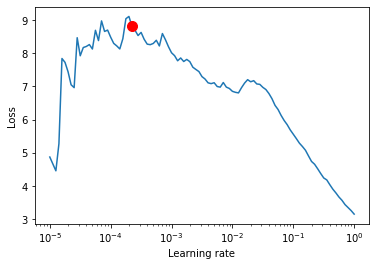

In [141]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [142]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_logger = LearningRateMonitor()

In [143]:
trainer = pl.Trainer(
    max_epochs = 10,
    gpus = 0,
    weights_summary = 'top',
    gradient_clip_val = .01,
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches = 30,
    enable_checkpointing = True,
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [144]:
torch.set_num_threads(10)

In [145]:
trainer.fit(
    net,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
)


  | Name                   | Type                      | Params
---------------------------------------------------------------------
0 | loss                   | LogNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                | 0     
2 | embeddings             | MultiEmbedding            | 0     
3 | rnn                    | LSTM                      | 11.4 K
4 | distribution_projector | Linear                    | 62    
---------------------------------------------------------------------
11.5 K    Trainable params
0         Non-trainable params
11.5 K    Total params
0.046     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: -0.010


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0001. New best score: -0.025


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0001. New best score: -0.046


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0001. New best score: -0.073


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.0001. New best score: -0.101


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0001. New best score: -0.135


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.0001. New best score: -0.172


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0.0001. New best score: -0.212


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.045 >= min_delta = 0.0001. New best score: -0.257


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.047 >= min_delta = 0.0001. New best score: -0.303


In [146]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [147]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(4568.8213)

In [148]:
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0
)

In [149]:
raw_predictions, x = net.predict(val_dataloader, mode="raw", return_x=True, n_samples=100)

In [152]:
predictions[0]

tensor([5.1853e-06, 5.1297e-06, 5.1468e-06, 5.1264e-06, 5.1288e-06, 5.1316e-06,
        5.1455e-06, 5.1548e-06, 5.1581e-06, 5.1335e-06, 5.1802e-06, 5.1501e-06,
        5.1681e-06, 5.1436e-06, 5.1713e-06, 5.1298e-06, 5.1519e-06, 5.1295e-06,
        5.1526e-06, 5.1538e-06])

In [159]:
raw_predictions[0].shape

torch.Size([188, 20, 100])

In [164]:
x['encoder_target']

tensor([[5.3100e-06, 5.2200e-06, 5.1000e-06,  ..., 5.2100e-06, 5.1400e-06,
         4.9600e-06],
        [2.7000e-07, 2.6000e-07, 2.6000e-07,  ..., 2.6000e-07, 2.6000e-07,
         2.5000e-07],
        [3.1290e-05, 3.0650e-05, 2.8290e-05,  ..., 2.3830e-05, 2.4490e-05,
         2.3090e-05],
        ...,
        [1.6018e-02, 1.6475e-02, 1.5200e-02,  ..., 1.1100e-02, 1.1253e-02,
         1.1592e-02],
        [9.2199e-02, 9.3900e-02, 8.6893e-02,  ..., 6.4395e-02, 6.9368e-02,
         6.8205e-02],
        [8.3800e-01, 8.4229e-01, 7.9298e-01,  ..., 6.8051e-01, 8.2645e-01,
         8.8100e-01]])

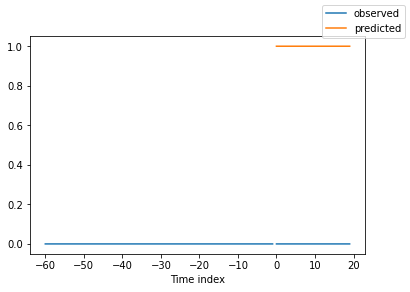

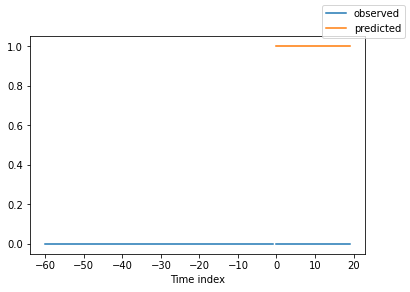

In [162]:
for idx in range(2):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);